# ESM2-15B PROTEIN EMBEDDINGS - CLASSIFICATION

In [1]:
import pandas as pd
#import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score, hamming_loss, classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import lightgbm as lgb
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [12,5]

/media/kingston/Pythonlibs/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
org = 'Homo sapiens (Human).'
#org = 'Mus musculus (Mouse).'

In [3]:
#kept = pd.read_csv('Kept.csv.gz', compression = 'gzip')

In [4]:
embeddings = np.load('Final_embeddings.npy')
metadata = pd.read_csv('Final_metadata.csv.gz', compression = 'gzip')[['Entry','Accession','Organism','GO']]

# Quedarnos con el organismo de interés
metadata = metadata[metadata['Organism'].isin([org])]
embeddings = embeddings[metadata.index]

In [5]:
print(embeddings.shape)
metadata

(19383, 5120)


,Entry,Accession,Organism,GO
3,1433B_HUMAN,P31946,Homo sapiens (Human).,GO:0005737; GO:0005829; GO:0070062; GO:0005925...
5,1433E_HUMAN,P62258,Homo sapiens (Human).,GO:0005737; GO:0005829; GO:0005783; GO:0070062...
7,1433F_HUMAN,Q04917,Homo sapiens (Human).,GO:0150048; GO:0005737; GO:0005829; GO:0070062...
9,1433G_HUMAN,P61981,Homo sapiens (Human).,GO:0005737; GO:0005829; GO:0070062; GO:0005925...
11,1433S_HUMAN,P31947,Homo sapiens (Human).,GO:0005737; GO:0005829; GO:0070062; GO:0005615...
...,...,...,...,...
36123,ZY11A_HUMAN,Q6WRX3,Homo sapiens (Human).,GO:0031462
36124,ZY11B_HUMAN,Q9C0D3,Homo sapiens (Human).,GO:0031462; GO:0005737; GO:0032436; GO:0006515
36126,ZYX_HUMAN,Q15942,Homo sapiens (Human).,GO:0015629; GO:0005912; GO:0005737; GO:0005829...
36128,ZZEF1_HUMAN,O43149,Homo sapiens (Human).,GO:0005509; GO:0140566; GO:0070577; GO:0035064...


## GO annotations preparation

The GO annotations need to be converted into separate binary variables.

In [6]:
# Eliminar espacios en blanco y otros errores
metadata['GO'] = metadata['GO'].str.replace(r"\s+", "", regex=True)

In [9]:
metadata['GO'].iloc[0]

'GO:0005737;GO:0005829;GO:0070062;GO:0005925;GO:0042470;GO:0016020;GO:0005634;GO:0048471;GO:0005774;GO:0045296;GO:0019899;GO:0042826;GO:0042802;GO:0051219;GO:0050815;GO:0019904;GO:0004860;GO:0004864;GO:0140311;GO:0045744;GO:0042308;GO:0045944;GO:0008104;GO:0006605;GO:0007165'

In [10]:
metadata['GO_annot'] = metadata['GO'].str.split(';')

In [11]:
mlb = MultiLabelBinarizer(sparse_output = True)
go_binary_matrix = mlb.fit_transform(metadata['GO_annot'])

In [12]:
go_df_sparse = pd.DataFrame.sparse.from_spmatrix(
    go_binary_matrix,
    index=metadata.index,
    columns=mlb.classes_
)

In [13]:
metadata_GO = pd.concat([
    metadata.drop(['GO','GO_annot'], axis = 1),
    go_df_sparse
], axis = 1)

In [14]:
# Estos son nuestros nuevos metadatos, ahora con cada anotación
# convertida en una variable nueva binaria
metadata_GO

,Entry,Accession,Organism,GO:0000002,GO:0000009,GO:0000012,GO:0000014,GO:0000015,GO:0000016,GO:0000017,...,GO:2001288,GO:2001294,GO:2001295,GO:2001299,GO:2001301,GO:2001302,GO:2001303,GO:2001304,GO:2001306,GO:2001311
3,1433B_HUMAN,P31946,Homo sapiens (Human).,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1433E_HUMAN,P62258,Homo sapiens (Human).,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1433F_HUMAN,Q04917,Homo sapiens (Human).,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1433G_HUMAN,P61981,Homo sapiens (Human).,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,1433S_HUMAN,P31947,Homo sapiens (Human).,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36123,ZY11A_HUMAN,Q6WRX3,Homo sapiens (Human).,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36124,ZY11B_HUMAN,Q9C0D3,Homo sapiens (Human).,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36126,ZYX_HUMAN,Q15942,Homo sapiens (Human).,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36128,ZZEF1_HUMAN,O43149,Homo sapiens (Human).,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## PCA

Reducir inicialmente la dimensionalidad.

In [18]:
#pca = PCA(n_components = 75)
pca = PCA(n_components = 200)

In [19]:
pca_embeddings = pca.fit_transform(embeddings)

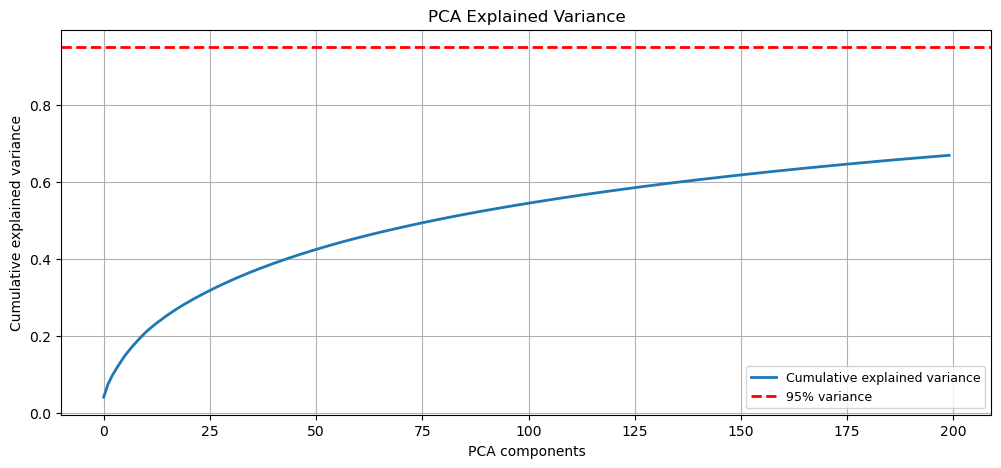

In [21]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), label = 'Cumulative explained variance', linewidth = 2)
plt.xlabel("PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.axhline(0.95, color='red', linestyle='--', label = '95% variance', linewidth = 2)
plt.legend(loc = 'best', prop = {'size' : 9})
plt.show()

## UMAP

In [22]:
# UMAP del PCA
reducer_pca = UMAP(
    n_components = 2,
    #metric = 'cosine',
    #n_neighbors = 50
)
umap_pca = reducer_pca.fit_transform(pca_embeddings, n_jobs = -1)

/usr/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [31]:
# UMAP de los embeddings crudos
reducer_raw = UMAP(
    n_components = 2,
    #metric = 'cosine',
    #n_neighbors = 50
)
umap_raw = reducer_raw.fit_transform(embeddings, n_jobs = -1)

/usr/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [23]:
most_frequent = (metadata_GO.iloc[:,3:].sum().sort_values(ascending = False) / len(metadata_GO) * 100)

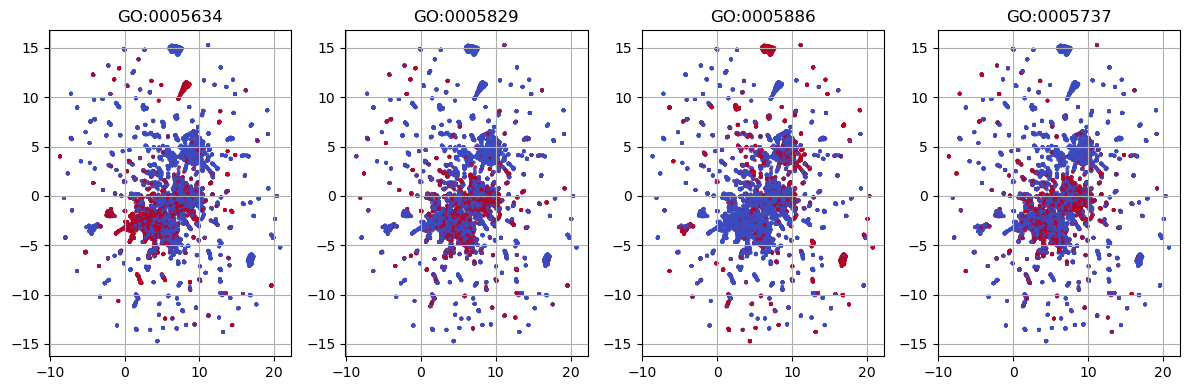

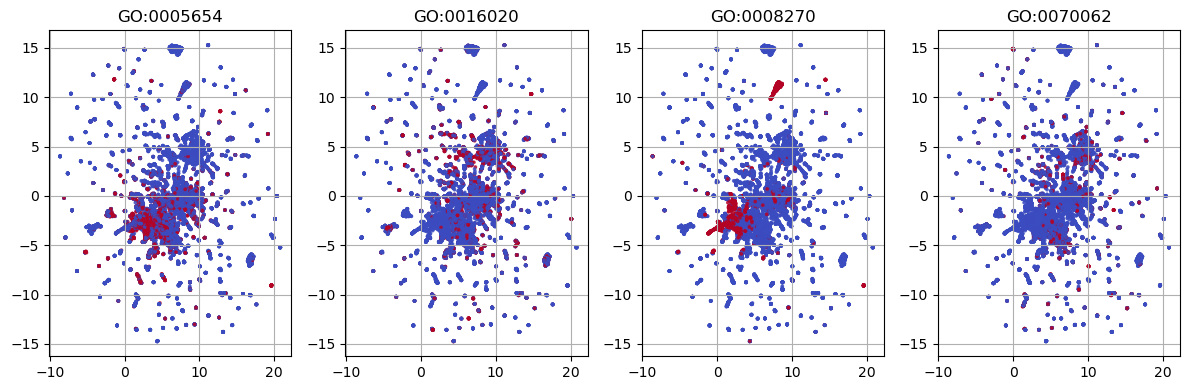

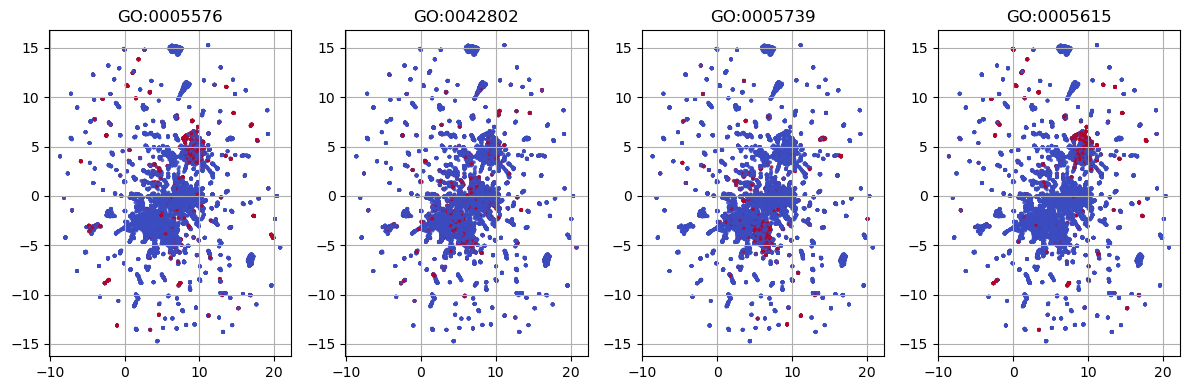

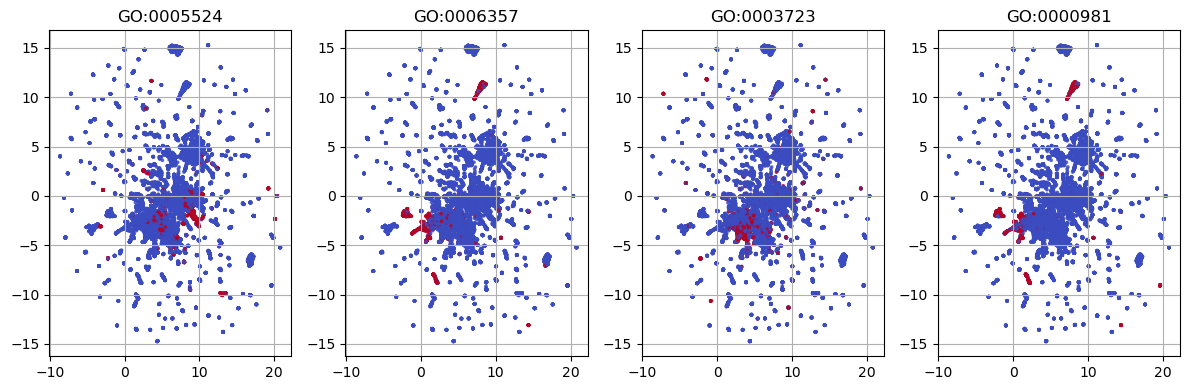

In [24]:
labels = [i for i in most_frequent[:4].index]
fig, axes = plt.subplots(1, len(labels), figsize=(12, 4))
for ax, label in zip(axes, labels):
    ax.grid(visible = True)
    sc = ax.scatter(
        umap_pca[:, 0],
        umap_pca[:, 1],
        c=metadata_GO[label],
        s=3,
        alpha=0.75,
        cmap='coolwarm',
        vmin=0,
        vmax=1
    )
    ax.set_title(label)
    #plt.colorbar(sc, ax=ax)

plt.tight_layout()
plt.show()

labels = [i for i in most_frequent[4:8].index]
fig, axes = plt.subplots(1, len(labels), figsize=(12, 4))
for ax, label in zip(axes, labels):
    ax.grid(visible = True)
    sc = ax.scatter(
        umap_pca[:, 0],
        umap_pca[:, 1],
        c=metadata_GO[label],
        s=3,
        alpha=0.75,
        cmap='coolwarm',
        vmin=0,
        vmax=1
    )
    ax.set_title(label)
    #plt.colorbar(sc, ax=ax)

plt.tight_layout()
plt.show()

labels = [i for i in most_frequent[8:12].index]
fig, axes = plt.subplots(1, len(labels), figsize=(12, 4))
for ax, label in zip(axes, labels):
    ax.grid(visible = True)
    sc = ax.scatter(
        umap_pca[:, 0],
        umap_pca[:, 1],
        c=metadata_GO[label],
        s=3,
        alpha=0.75,
        cmap='coolwarm',
        vmin=0,
        vmax=1
    )
    ax.set_title(label)
    #plt.colorbar(sc, ax=ax)

plt.tight_layout()
plt.show()

labels = [i for i in most_frequent[12:16].index]
fig, axes = plt.subplots(1, len(labels), figsize=(12, 4))
for ax, label in zip(axes, labels):
    ax.grid(visible = True)
    sc = ax.scatter(
        umap_pca[:, 0],
        umap_pca[:, 1],
        c=metadata_GO[label],
        s=3,
        alpha=0.75,
        cmap='coolwarm',
        vmin=0,
        vmax=1
    )
    ax.set_title(label)
    #plt.colorbar(sc, ax=ax)

plt.tight_layout()
plt.show()

## Classification

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

In [27]:
print(embeddings.shape)
print(pca_embeddings.shape)

(19383, 5120)
(19383, 200)


In [28]:
#annotations = [
#    'GO:0005634',
#    'GO:0005886',
#    'GO:0005829',
#    'GO:0008270',
#    'GO:0006357'
#]

annotations = [i for i in most_frequent[:20].index]

full_metrics = pd.DataFrame()

for annot in tqdm(annotations):
    
    X_train, X_test, y_train, y_test = train_test_split(
        #embeddings[:], # X
        pca_embeddings[:],
        metadata_GO[[annot]][:].values, # Regulación de transcripción a través de RNApol II
        test_size = 0.25
    )

    #model = RandomForestClassifier(
    #    random_state = 1,
    #    n_jobs = -1,
    #    class_weight = 'balanced' # Hay un desequilibrio extremo de clases
    #    #class_weight = 'balanced_subsample'
    #)
    
    model = lgb.LGBMClassifier(
        n_jobs = -1,
        objective = 'binary',
        class_weight = 'balanced',
        random_state = 1
    )
    
    if y_test.shape[1] == 1:
        model.fit(X_train, np.ravel(y_train))
        y_pred = model.predict(X_test)
        
    elif y_test.shape[1] > 1:
        # Predecir múltiples funciones a la vez (Y DEBE SER MULTIDIMENSIONAL!)
        # Entrena el modelo interno una vez por cada etiqueta
        clf = MultiOutputClassifier(model)
        clf.fit(X_train, np.ravel(y_train))
        y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)# Inútil: sale siempre alta porque casi todas las ocurrencias son '0'

    if y_test.shape[1] == 1:
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        metrics = {
            'Accuracy' : acc,
            'F1' : f1,
            'Precision' : precision,
            'Recall' : recall
        }

    elif y_test.shape[1] > 1:

        f1_micro = f1_score(y_test, y_pred, average = 'micro')
        f1_macro = f1_score(y_test, y_pred, average = 'macro')

        hamming = hamming_loss(y_test, y_pred)

        precision_micro = precision_score(y_test, y_pred, average = 'micro')
        recall_micro = recall_score(y_test, y_pred, average = 'micro')

        precision_macro = precision_score(y_test, y_pred, average = 'macro')
        recall_macro = recall_score(y_test, y_pred, average = 'macro')

        metrics = {
            'Accuracy' : acc,
            'F1 micro' : f1_micro,
            'F1 macro' : f1_macro,
            
            'Hamming' : hamming,
            
            'Precision (micro)' : precision_micro,
            'Recall (micro)' : recall_micro,
            
            'Precision (macro)' : precision_macro,
            'Recall (macro)' : recall_macro,
        }

    metrics = pd.DataFrame([metrics])
    metrics['GO'] = annot
    
    full_metrics = pd.concat([
        full_metrics,
        metrics
    ])

  0%|                                                                                                                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4252, number of negative: 10285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
  5%|██████▋                                                                                                                               | 1/20 [00:03<01:02,  3.31s/it]

[LightGBM] [Info] Number of positive: 4137, number of negative: 10400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 10%|█████████████▍                                                                                                                        | 2/20 [00:06<01:01,  3.39s/it]

[LightGBM] [Info] Number of positive: 3989, number of negative: 10548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 15%|████████████████████                                                                                                                  | 3/20 [00:10<00:57,  3.39s/it]

[LightGBM] [Info] Number of positive: 3951, number of negative: 10586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 20%|██████████████████████████▊                                                                                                           | 4/20 [00:13<00:56,  3.55s/it]

[LightGBM] [Info] Number of positive: 2986, number of negative: 11551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 25%|█████████████████████████████████▌                                                                                                    | 5/20 [00:18<00:56,  3.75s/it]

[LightGBM] [Info] Number of positive: 2426, number of negative: 12111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 30%|████████████████████████████████████████▏                                                                                             | 6/20 [00:21<00:50,  3.63s/it]

[LightGBM] [Info] Number of positive: 1636, number of negative: 12901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 35%|██████████████████████████████████████████████▉                                                                                       | 7/20 [00:25<00:48,  3.74s/it]

[LightGBM] [Info] Number of positive: 1577, number of negative: 12960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 40%|█████████████████████████████████████████████████████▌                                                                                | 8/20 [00:29<00:46,  3.88s/it]

[LightGBM] [Info] Number of positive: 1501, number of negative: 13036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 45%|████████████████████████████████████████████████████████████▎                                                                         | 9/20 [00:34<00:44,  4.07s/it]

[LightGBM] [Info] Number of positive: 1269, number of negative: 13268
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 50%|██████████████████████████████████████████████████████████████████▌                                                                  | 10/20 [00:38<00:40,  4.07s/it]

[LightGBM] [Info] Number of positive: 1241, number of negative: 13296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 55%|█████████████████████████████████████████████████████████████████████████▏                                                           | 11/20 [00:42<00:36,  4.07s/it]

[LightGBM] [Info] Number of positive: 1217, number of negative: 13320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 60%|███████████████████████████████████████████████████████████████████████████████▊                                                     | 12/20 [00:45<00:31,  3.95s/it]

[LightGBM] [Info] Number of positive: 1114, number of negative: 13423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 65%|██████████████████████████████████████████████████████████████████████████████████████▍                                              | 13/20 [00:49<00:27,  3.88s/it]

[LightGBM] [Info] Number of positive: 1083, number of negative: 13454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 14/20 [00:53<00:23,  3.87s/it]

[LightGBM] [Info] Number of positive: 1054, number of negative: 13483
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15/20 [00:57<00:19,  3.89s/it]

[LightGBM] [Info] Number of positive: 933, number of negative: 13604
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16/20 [01:02<00:16,  4.13s/it]

[LightGBM] [Info] Number of positive: 846, number of negative: 13691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17/20 [01:07<00:13,  4.44s/it]

[LightGBM] [Info] Number of positive: 857, number of negative: 13680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 18/20 [01:11<00:08,  4.40s/it]

[LightGBM] [Info] Number of positive: 832, number of negative: 13705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19/20 [01:15<00:04,  4.20s/it]

[LightGBM] [Info] Number of positive: 819, number of negative: 13718
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 14537, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.98s/it]


## Get GO annotations descriptions
We translate the GO annotations with their descriptions to understand what they refer to.

In [29]:
import requests
from time import sleep

In [30]:
descriptions = []
for go in tqdm(full_metrics['GO']):
    url = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{go}"
    response = requests.get(url, headers={"Accept": "application/json"})
    data = response.json()

    term = data['results'][0]
    #print(term['name'])        # Term name
    descriptions.append(term['name'])
    #print(term.get('definition', 'No definition available'))
    
    sleep(5) # Adjust to not overload the page with requests

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:49<00:00,  5.45s/it]


In [31]:
full_metrics['GO_desc'] = descriptions

In [32]:
full_metrics.sort_values(['F1','Precision', 'Recall'], ascending = False).reset_index(drop = True).round(2)

,Accuracy,F1,Precision,Recall,GO,GO_desc
0,0.99,0.90,0.92,0.89,GO:0005524,ATP binding
1,0.98,0.86,0.80,0.94,GO:0000981,"DNA-binding transcription factor activity, RNA..."
2,0.97,0.86,0.89,0.82,GO:0008270,zinc ion binding
3,0.97,0.79,0.74,0.84,GO:0006357,regulation of transcription by RNA polymerase II
4,0.87,0.77,0.75,0.79,GO:0005886,plasma membrane
5,0.97,0.73,0.72,0.74,GO:0000785,chromatin
6,0.83,0.72,0.70,0.75,GO:0005634,nucleus
7,0.94,0.69,0.61,0.79,GO:0005615,extracellular space
8,0.92,0.67,0.60,0.75,GO:0005576,extracellular region
9,0.78,0.66,0.59,0.75,GO:0005829,cytosol


# CO-OCCURRENCE OF GO TERMS

By definition, GO annotations co-occur. What are the most common combinations of them in the data?

In [41]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [56]:
frequent_itemsets = apriori(
    metadata_GO.iloc[:, 3:], # Exclude anything else other than our binary-encoded GO annotations
    min_support = 0.05, # Minimal percentage occurrence of a combination to be relevant
    use_colnames = True
)

/home/adan/.local/lib/python3.13/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [57]:
frequent_itemsets[frequent_itemsets['itemsets'].apply(len) >= 2]

,support,itemsets
25,0.050818,"(GO:0005634, GO:0000785)"
26,0.050766,"(GO:0005634, GO:0000978)"
27,0.059176,"(GO:0000981, GO:0005634)"
28,0.051179,"(GO:0000981, GO:0006357)"
29,0.133003,"(GO:0005634, GO:0005654)"
30,0.120931,"(GO:0005634, GO:0005737)"
31,0.115410,"(GO:0005634, GO:0005829)"
32,0.066966,"(GO:0006357, GO:0005634)"
33,0.069236,"(GO:0005634, GO:0008270)"
34,0.079451,"(GO:0005654, GO:0005737)"


In [58]:
#frequent_itemsets.sort_values(
frequent_itemsets[frequent_itemsets['itemsets'].apply(len) >= 2].sort_values( # Focus only on combinations of two or more GO terms
    'support',
    ascending = False
).head(20).reset_index(drop = True)

,support,itemsets
0,0.133003,"(GO:0005634, GO:0005654)"
1,0.130475,"(GO:0005829, GO:0005737)"
2,0.120931,"(GO:0005634, GO:0005737)"
3,0.115410,"(GO:0005634, GO:0005829)"
4,0.102255,"(GO:0005829, GO:0005654)"
5,0.079451,"(GO:0005654, GO:0005737)"
6,0.069803,"(GO:0005886, GO:0005829)"
7,0.069236,"(GO:0005634, GO:0008270)"
8,0.067224,"(GO:0005634, GO:0005829, GO:0005737)"
9,0.066966,"(GO:0006357, GO:0005634)"


In [64]:
association_rules(
    frequent_itemsets,
    metric = "confidence",
    min_threshold = 0.8
)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(GO:0000785),(GO:0005634),0.056493,0.293453,0.050818,0.899543,3.065374,1.0,0.034240,7.033354,0.714118,0.169886,0.857820,0.536357
1,(GO:0000978),(GO:0005634),0.055564,0.293453,0.050766,0.913649,3.113442,1.0,0.034461,8.182270,0.718749,0.170213,0.877785,0.543322
2,(GO:0000981),(GO:0005634),0.063458,0.293453,0.059176,0.932520,3.177750,1.0,0.040554,10.470515,0.731747,0.198752,0.904494,0.567086
3,(GO:0000981),(GO:0006357),0.063458,0.073931,0.051179,0.806504,10.908910,1.0,0.046487,4.785988,0.969878,0.593656,0.791057,0.749379
4,(GO:0006357),(GO:0005634),0.073931,0.293453,0.066966,0.905792,3.086668,1.0,0.045271,7.499865,0.729995,0.222909,0.866664,0.566996
